In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "MIG-40f43250-998e-586a-ac37-d6520e92590f"
#os.environ["CUDA_VISIBLE_DEVICES"] = "3"

In [3]:
import sys
sys.path.append('../2_train_models')

In [57]:
import numpy as np
import torch
import matplotlib.pyplot as plt

#from data_loading import read_fasta_fast, one_hot_encode

cell_type = "K562"
timestamps = ["2023-05-29_15-51-40",
              "2023-05-29_15-58-41",
              "2023-05-29_15-59-09",
              "2023-05-30_01-40-06",
              "2023-05-29_23-21-23",
              "2023-05-29_23-23-45",
              "2023-05-29_23-24-11"]
model_type = "strand_merged_umap"
data_type = "procap"

from file_configs import FoldFilesConfig

In [115]:
config = FoldFilesConfig(cell_type, model_type, "2", timestamps[1], data_type)
in_window = 2114
out_window = 1000

Timestamp: 2023-05-29_15-58-41


In [116]:
import pyBigWig
from data_loading import read_fasta_fast, one_hot_encode

def load_sequence_at_locus(chrom, start, end, genome_path):
    genome = read_fasta_fast(genome_path, include_chroms = [chrom])
    seq = genome[chrom][start:end]
    onehot_seq = one_hot_encode(seq).T
    return seq, onehot_seq


def load_observed_profile_at_locus(chrom, start, end, plus_bw_path, minus_bw_path):
    with pyBigWig.open(plus_bw_path, "r") as plus_bw:
        plus_sig = plus_bw.values(chrom, start, end, numpy=True)
    plus_sig = np.nan_to_num(plus_sig)

    with pyBigWig.open(minus_bw_path, "r") as minus_bw:
        minus_sig = minus_bw.values(chrom, start, end, numpy=True)
    minus_sig = np.nan_to_num(minus_sig)

    signal = np.array([plus_sig, minus_sig])
    return signal


def get_locus_data(chrom, start, end, config):
    genome_path = config.genome_path
    plus_bw_path = config.plus_bw_path
    minus_bw_path = config.minus_bw_path
    
    mid = (start + end) // 2
    seq_start = mid - in_window // 2
    seq_end = seq_start + in_window
    seq, onehot_seq = load_sequence_at_locus(chrom, seq_start, seq_end, genome_path)
    
    prof_start = mid - out_window // 2
    prof_end = prof_start + out_window
    prof = load_observed_profile_at_locus(chrom, prof_start, prof_end, plus_bw_path, minus_bw_path)
    
    return seq, onehot_seq, prof


# MYC promoter
chrom, start, end = ["chr8", 127735875, 127736475]

og_seq, og_onehot_seq, og_prof = get_locus_data(chrom, start, end, config)

Loading genome sequence from /mnt/lab_data2/kcochran/procapnet/genomes/hg38.withrDNA.fasta


Reading FASTA: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.04it/s]


In [117]:
def load_model(val_config):
    model = torch.load(val_config.model_save_path)
    model.eval()
    model = model.cuda()
    return model

model = load_model(config)

In [118]:
def predict(onehot_seq, model):
    with torch.no_grad():
        onehot_seq = torch.tensor(onehot_seq, dtype=torch.float32)[None,...].cuda()
        pred_profs, pred_logcounts = model.predict(onehot_seq)

    pred_prof = np.exp(pred_profs.squeeze())
    pred_counts = np.exp(pred_logcounts.squeeze())
    pred_prof = pred_prof * pred_counts
    return pred_prof

og_pred_prof = predict(og_onehot_seq, model)

In [119]:
sys.path.append('../4_interpret_models')

from captum.attr import DeepLiftShap
from deepshap_utils import ProfileModelWrapper
from dinuc_shuffle import dinuc_shuffle


prof_shap_explainer = DeepLiftShap(ProfileModelWrapper(model))


def deepshap(seq):
    if type(seq) == str:
        seq = one_hot_encode(seq).T
    if len(seq.shape) < 3:
        seq = seq[None,...]
    
    seq = torch.tensor(seq).float()

    ref_seqs = dinuc_shuffle(seq[0], 25).float().cuda()
    prof_attrs = prof_shap_explainer.attribute(seq.cuda(), ref_seqs).cpu()
    prof_attrs = prof_attrs * seq
    return prof_attrs.squeeze().detach().numpy()

og_prof_attr = deepshap(og_onehot_seq)

/users/kcochran/miniconda3/envs/procap_A100/lib/python3.9/site-packages/captum/attr/_core/deep_lift.py:336: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


In [120]:
# originally tried - not all will go in figure
mutate_positions = [526, 554, 554, 366, 508, 445, 443, 498]
mutate_seqs = ["GGGG", "GG", "CGGCA", "CGGC", "CTAGCTA", "CC", "A", "AGTG"]
mutate_labels = ["Right TATA\nAblated",
                 "Right Inr\nAblated",
                 "Right Inr\nAblated # 2",
                 "Left TATA\nAblated",
                 "BRE\nAblated",
                 "Left Inr\nAblated",
                 "Left Inr\nImproved",
                 "Added Inr\n-30 from TATA"]

# what to actually use for figure
mutate_positions = [526, 554, 366, 508, 443]
mutate_seqs = ["GGGG", "GGT", "CGGC", "CTAGCTA", "A"]
mutate_labels = ["Right TATA\nAblated",
                 "Major Inr\nAblated",
                 "Left TATA\nAblated",
                 "BRE\nAblated",
                 "Minor Inr\nStrengthened"]


assert len(mutate_positions) == len(mutate_seqs)
assert len(mutate_seqs) == len(mutate_labels)

mutate_lens = [len(seq) for seq in mutate_seqs]

In [121]:
def get_mutated_prof_preds_and_attrs(og_onehot_seq, mutate_positions, mutate_seqs):
    pred_profs = []
    attrs = []
    for mutate_pos, mutate_to in zip(mutate_positions, mutate_seqs):
            mutate_pos = mutate_pos + (in_window - out_window) // 2
            new_seq_onehot = [og_onehot_seq[:, :mutate_pos]]
            new_seq_onehot += [one_hot_encode(mutate_to).T]
            new_seq_onehot += [og_onehot_seq[:, mutate_pos + len(mutate_to):]]
            new_seq_onehot = np.concatenate(new_seq_onehot, axis=-1)

            pred_prof = predict(new_seq_onehot, model)
            pred_profs.append(pred_prof)
            
            attr = deepshap(new_seq_onehot)
            attrs.append(attr)
        
    return pred_profs, attrs

mutate_pred_profs, mutate_attrs = get_mutated_prof_preds_and_attrs(og_onehot_seq,
                                                                   mutate_positions,
                                                                   mutate_seqs)

In [122]:
#import viz_sequence
from other_motif_utils import plot_motif_on_ax

def slice_to_prof_len(attrs, prof_len = out_window):
    assert attrs.shape[-1] >= prof_len, attrs.shape
    mid = attrs.shape[-1] / 2
    prof_start = int(mid - prof_len / 2)
    prof_end = int(mid + prof_len / 2)
    return attrs[..., prof_start : prof_end ]


def plot_prof_on_ax(profile, ax, zoom_start, zoom_end,
                    color = "#001DAC", alphas = [1, 0.7],
                    linewidth=1, x_axis_buffer=0):
    
    x_range = np.arange(zoom_start, zoom_end)
    offset = np.max(np.abs(profile[:, zoom_start:zoom_end])) * 0.02
    ax.plot(x_range, profile[0, zoom_start:zoom_end] + offset,
            alpha = alphas[0], c = color, linewidth=linewidth)
    ax.plot(x_range, -1 * profile[1, zoom_start:zoom_end] - offset,
            alpha = alphas[1], c = color, linewidth=linewidth)

    ax.set_xlim(zoom_start - x_axis_buffer, zoom_end + x_axis_buffer)
    
    
def get_prof_plot_lims(profs, zoom_start, zoom_end):
    neg_max_so_far = 0
    max_so_far = 0
    for prof in profs:
        max_so_far = max(max_so_far, np.max(prof[0, zoom_start:zoom_end]))
        neg_max_so_far = max(neg_max_so_far, np.max(prof[1, zoom_start:zoom_end]))
    return -1 * neg_max_so_far, max_so_far 

def get_attr_plot_lims(attrs, zoom_start, zoom_end):
    neg_max_so_far = 0
    max_so_far = 0
    for attr in attrs:
        attr = slice_to_prof_len(attr)
        max_so_far = max(max_so_far, np.max(attr[:, zoom_start:zoom_end]))
        neg_max_so_far = min(neg_max_so_far, np.min(attr[:, zoom_start:zoom_end]))
    return neg_max_so_far, max_so_far 

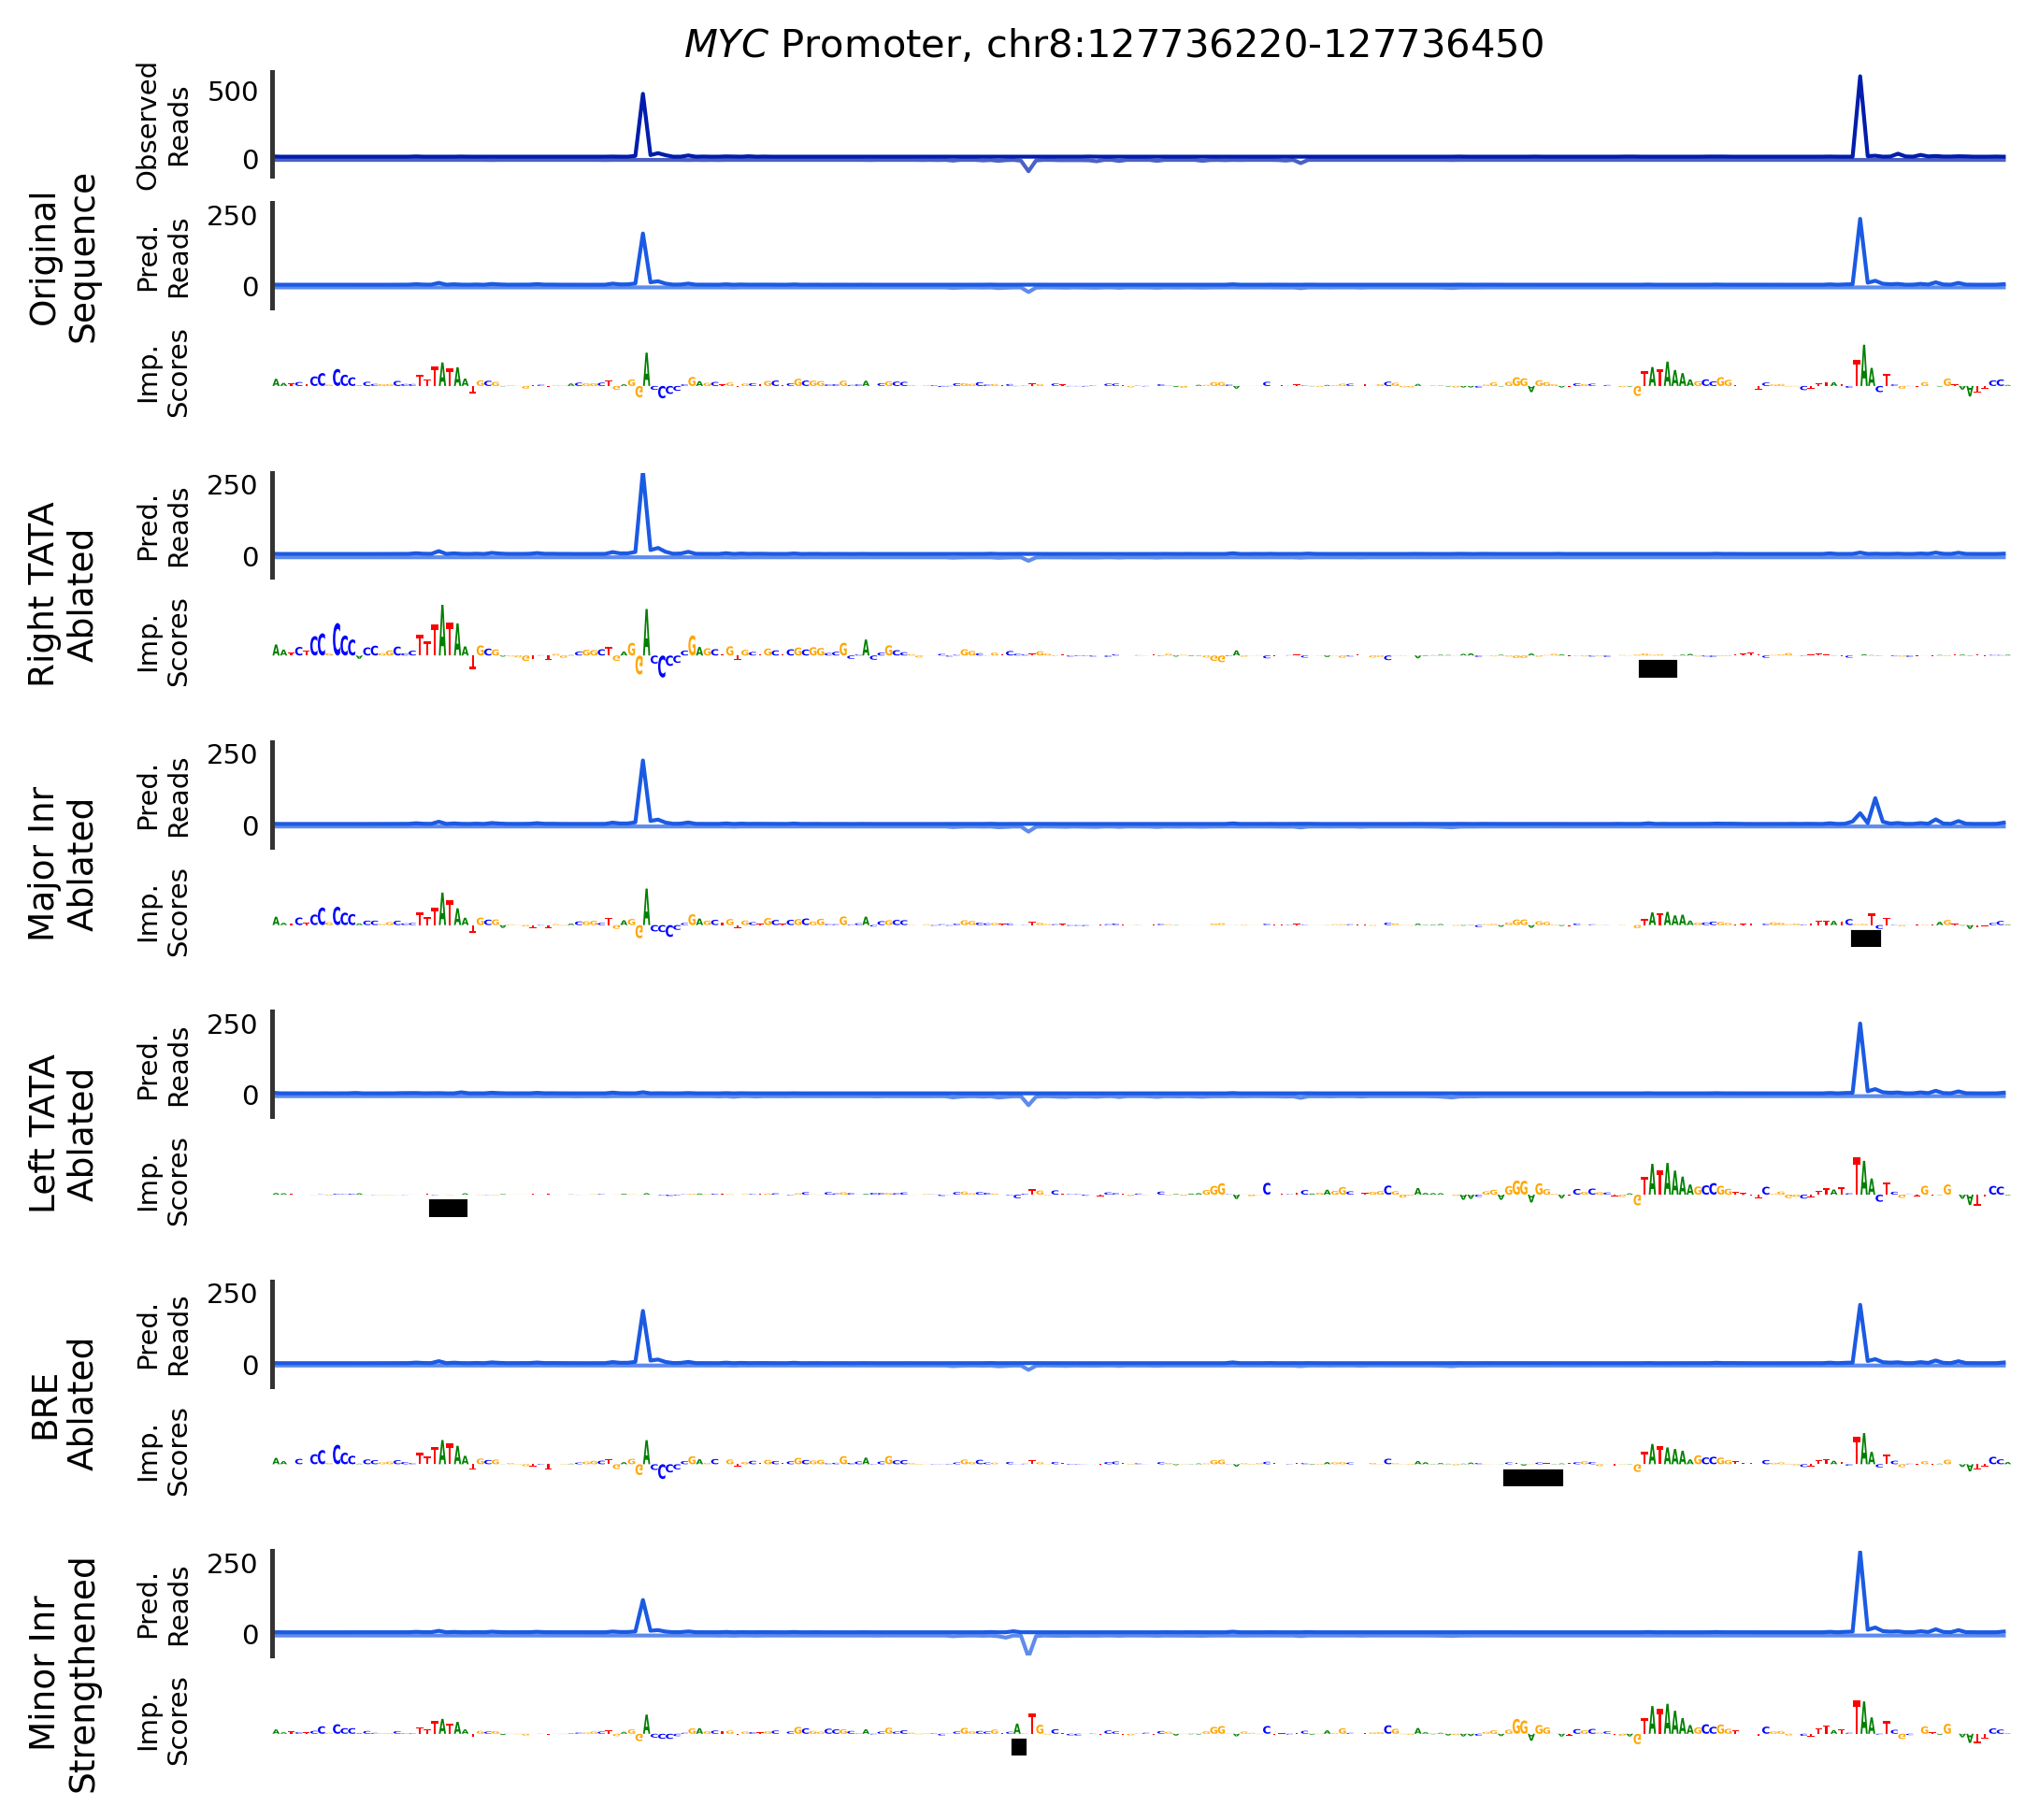

In [123]:
from matplotlib.patches import Rectangle

def plot_mutate_effect_with_attrs(og_seq, og_onehot_seq,
                                  true_profile, og_pred_profile, og_prof_attr,
                                  mutate_pred_profs, mutate_attrs, mutate_labels,
                                  mutate_positions, mutate_lens,
                                  prof_len = out_window, save_path = None,
                                  zoom_midpoint = 460, zoom_width = 230):
    
    assert len(mutate_pred_profs) == len(mutate_attrs), (len(mutate_pred_profs), len(mutate_attrs))
    assert len(mutate_positions) == len(mutate_lens), (len(mutate_positions), len(mutate_lens))
    
    plot_params = {"xtick.labelsize": 8, "ytick.labelsize": 8}
    plt.rcParams.update(plot_params)
    
    num_subplots = 3 + 2 * len(mutate_positions)
    num_actual_subplots = 3 + 3 * len(mutate_positions)
    height_ratios = [10,10,7] + [1,10,7] * len(mutate_positions)
    
    fig = plt.figure(figsize=(8, 0.6 * num_subplots), dpi=300)
    gs = fig.add_gridspec(num_actual_subplots, height_ratios = height_ratios, hspace=0.4)
    axes = gs.subplots()

    
    zoom_start = min(max(zoom_midpoint - zoom_width//2, 0), prof_len - zoom_width)
    zoom_end = zoom_start + zoom_width
    
    title = r'$\it{MYC}$ Promoter, ' + chrom + ":" + str(start + zoom_start) + "-" + str(start + zoom_end)
    fig.suptitle(title, y = 0.9, fontsize=10, horizontalalignment='center')
    
    
    pred_prof_min, pred_prof_max = get_prof_plot_lims([og_pred_profile] + mutate_pred_profs,
                                                      zoom_start, zoom_end)
    attr_min, attr_max = get_attr_plot_lims([og_prof_attr] + mutate_attrs,
                                            zoom_start, zoom_end)
    axis_fontsize = 7
    axis_labelpad = 4
    axis_index = 0
        
    
    plot_prof_on_ax(true_profile, axes[axis_index], zoom_start, zoom_end,
                    color = "#001DAC")
    axes[axis_index].set_ylabel("Observed\nReads", fontsize = axis_fontsize, rotation=90, labelpad=axis_labelpad)

    axis_index += 1
    
    plot_prof_on_ax(og_pred_profile, axes[axis_index], zoom_start, zoom_end,
                    color = "#1B5AE3")
    
    axes[axis_index].set_ylabel("Pred.\nReads", fontsize = axis_fontsize, rotation=90, labelpad=axis_labelpad)
    axes[axis_index].set_ylim(pred_prof_min, pred_prof_max)
    axis_index += 1
    
    og_prof_attr = slice_to_prof_len(og_prof_attr)[:, zoom_start : zoom_end].T
    plot_motif_on_ax(og_prof_attr, axes[axis_index])
    
    axes[axis_index].set_ylabel("Imp.\nScores",
                                fontsize = axis_fontsize, rotation=90,
                                labelpad=axis_labelpad)
    axes[axis_index].set_ylim(attr_min, attr_max)
    
    axes[axis_index].text(-28, attr_max, "Original\nSequence", ha="center", fontsize=9, rotation=90)
    
    axis_index += 1
    
    for mutate_prof, mutate_attr, label, mutate_pos, mutate_len in zip(mutate_pred_profs, mutate_attrs, mutate_labels, mutate_positions, mutate_lens):
        axis_index += 1
        
        plot_prof_on_ax(mutate_prof, axes[axis_index], zoom_start, zoom_end,
                        color = "#1B5AE3")
        
        axes[axis_index].set_ylabel("Pred.\nReads", fontsize = axis_fontsize, rotation=90, labelpad=axis_labelpad)
        axes[axis_index].set_ylim(pred_prof_min, pred_prof_max)
        
        axis_index += 1
        mutate_attr = slice_to_prof_len(mutate_attr)[:, zoom_start : zoom_end].T
        plot_motif_on_ax(mutate_attr, axes[axis_index])
        
        axes[axis_index].set_ylabel("Imp.\nScores",
                                    fontsize = axis_fontsize, rotation=90,
                                    labelpad=axis_labelpad)
        axes[axis_index].set_ylim(attr_min, attr_max)
        
        # highlight where ablation happened
        axes[axis_index].add_patch(Rectangle((mutate_pos - zoom_start - 0.5, -0.075),
                                             mutate_len + 0.5, 0.05,
                                             color="k"))
        
        axes[axis_index].text(-28, attr_max * 1.2, label, ha="center", va="center", fontsize=9, rotation=90)
        
        # skip tiny subplot that exists to add spacing
        axis_index += 1
    
    
    axis_index -= 1  # fix off-by-one error from loop above (no spacing subplot after last set of subplots)
    curr_xticks = axes[axis_index].get_xticks()
    axes[axis_index].set_xticks(curr_xticks, [int(tick_pos + zoom_start) for tick_pos in curr_xticks])
    
    for ax_i, ax in enumerate(axes):
        ax.tick_params(left=False, length=0, labelsize=7)
        
        if height_ratios[ax_i] == 1:  # is this one of the spacing subplots?
            ax.spines["left"].set_visible(False)
            ax.set_yticks([])
        else:
            ax.spines[["left", "bottom"]].set_linewidth(1.2)
            ax.spines[["left", "bottom"]].set_color("#333333")
        ax.spines[["top", "right"]].set_visible(False)
        
        ax.spines['bottom'].set_visible(False)
        ax.set_xticks([])
    
    fig.align_ylabels()
    
    if save_path is not None:
        plt.savefig(save_path, bbox_inches = 'tight', pad_inches = 0, dpi = 300)

    plt.show()

    
proj_dir = os.path.dirname(os.path.dirname(os.path.realpath(os.getcwd()))) + "/"

figures_dir = proj_dir + "figures/"
    
plot_mutate_effect_with_attrs(og_seq, og_onehot_seq,
                              og_prof, og_pred_prof, og_prof_attr,
                              mutate_pred_profs, mutate_attrs, mutate_labels,
                              mutate_positions, mutate_lens,
                              prof_len = out_window, save_path = figures_dir + "4.png")

In [114]:
# need to fix chrom:start-end coords to actually match where I zoomed to